# Feasibility problem

Let us consider $M$ balls in $\mathbb{R}^n$, where the $i$-th ball of radius $r_i > 0$ centered in $\mathbf{c}_i \in \mathbb{R}^n$ is given by $\mathcal{B}_i(\mathbf{c}_i, r_i) \subset \mathbb{R}^n$. We are interested in finding a point belonging to their intersection, i.e., we want to solve the following

$$
\begin{equation} 
    \label{eq:intersection}
    \text{find} \ \mathbf{x} \ \text{subject to} \ \mathbf{x} \in \bigcap_{i = 1}^M \mathcal{B}_i(\mathbf{c}_i, r_i)
\end{equation}
$$

It is straightforward to verify that the projection of a point onto $\mathcal{B}_i(\mathbf{c}_i,r_i)$ is evaluated as

$$
\begin{equation}
    \label{eq:projection}
    \mathbf{P}_i(\mathbf{x}) := 
    \text{proj}_{\mathcal{B}_i(\mathbf{c}_i,r_i)}(\mathbf{x}) = 
    \begin{cases}
        \displaystyle r_i\frac{\mathbf{x} - 
        \mathbf{c}_i}{\|\mathbf{x} - \mathbf{c}_i\|} & \text{if} \ \|\mathbf{x} - \mathbf{c}_i\| > r_i \\
        \mathbf{x} & \text{otherwise}
    \end{cases}
\end{equation}
$$

Due to the non-expansiveness of the projection in $\eqref{eq:projection}$, one can find a solution for $\eqref{eq:intersection}$ as the fixed point of the following iterate 

$$
\begin{equation}
    \label{eq:krasnoselskii-mann}
    \mathbf{x}_{k+1} = \mathbf{T}(\mathbf{x}_k) = \frac{1}{M}\sum_{i = 1}^M\mathbf{P}_i(\mathbf{x}_k) 
\end{equation}
$$

which result from the well-known Krasnoselskii-Mann iterate. By letting $\mathbf{F} = \mathbf{I} - \mathbf{T}$, where $\mathbf{I}$ denotes the identity operator, the fixed point for $\eqref{eq:krasnoselskii-mann}$ can be treated as the canonical VI [1]. 

Let's start by creating the problems' data.

In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

from monviso import VI

np.random.seed(2024)

# Problem data
n, M = 10, 50
c = np.random.normal(0, 100, size=(M, n))
r = 1 - np.linalg.norm(c, axis=0)

Then, let's create the projection operator $\mathbf{P}(\cdot)$ and the VI mapping $\mathbf{F}(\cdot)$. 

In [2]:
P = lambda x: np.where(
    np.linalg.norm(x - c) > r, 
    r * (x - c) / np.linalg.norm(x - c, axis=0), 
    x
)
T = lambda x: P(x).mean(axis=0)
F = lambda x: x - T(x)

Finally, let's instantiate the VI with and initial solution. Note that $\mathcal{X} = \mathbb{R}^n$, so the proximal operator is the identity itself. 

In [3]:
fp = VI(F)
x = np.random.rand(n)

The projection $\mathbf{P}(\cdot)$ is merely monotone, so $\mathbf{F}(\cdot)$ is merely monotone as well. As examples, we can use the forward-reflected-backward ([`frb`](../../api/#forward-reflected-backward)), the projected reflected gradient ([`prg`](../../api/#projected-reflected-gradient)), and the extra anchored gradient ([`eag`](../../api/#extra-anchored-gradient)).

In [22]:
max_iter = 200
step_size = 0.01

residuals_frb = np.zeros(max_iter)
residuals_prg = np.zeros(max_iter)
residuals_eag = np.zeros(max_iter)

# Copy the same initial solution for the three methods
xk_frb, x1k_frb = np.copy(x), np.copy(x)
xk_prg, x1k_prg = np.copy(x), np.copy(x)
xk_eag, x0_eag = np.copy(x), np.copy(x)

for k in range(max_iter):
    # Forward-reflected-backward
    xk1_frb = fp.frb(xk_frb, x1k_frb, step_size)
    residuals_frb[k] = np.linalg.norm(xk1_frb - xk_frb)
    xk_frb, x1k_frb = xk1_frb, xk_frb

    # Projected reflected gradient
    xk1_prg = fp.prg(xk_prg, x1k_prg, step_size)
    residuals_prg[k] = np.linalg.norm(xk1_prg - xk_prg)
    xk_prg = xk1_prg

    # Extra anchored gradient
    xk1_eag = fp.eag(xk_eag, x0_eag, k, step_size)
    residuals_eag[k] = np.linalg.norm(xk1_eag - xk_eag)
    xk_eag = xk1_eag

The API docs have some detail on the [convention for naming iterative steps](../../api/#iterative-methods). Let's check out the residuals for each method. 

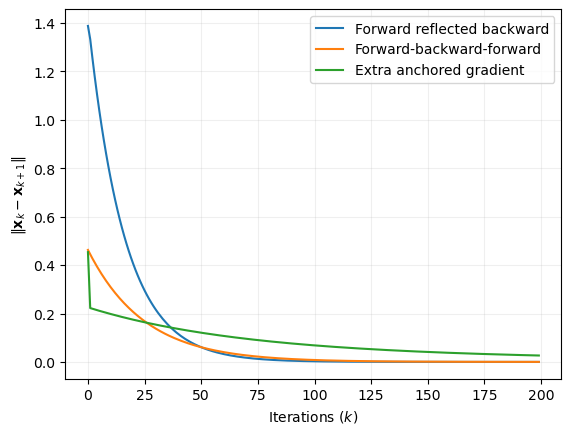

In [23]:
fig, ax = plt.subplots()

ax.plot(residuals_frb, label="Forward reflected backward")
ax.plot(residuals_prg, label="Forward-backward-forward")
ax.plot(residuals_eag, label="Extra anchored gradient")

ax.grid(True, alpha=0.2)
ax.set_xlabel("Iterations ($k$)")
ax.set_ylabel(r"$\|\mathbf{x}_k - \mathbf{x}_{k+1}\|$")
plt.legend()
plt.show()

## References
[1] Bauschke, H. H., & Borwein, J. M. (1996). On projection algorithms for solving convex feasibility problems. SIAM review, 38(3), 367-426.